# 2. 동물 이미지 분류 예측을 위한 최적의 CNN 모형 찾기
- data: kaggle의 Animal Images Dataset <br>
(출처:https://www.kaggle.com/lasaljaywardena/animal-images-dataset)
- 프로젝트 목적: 본 분석에서는 동물의 이미지 데이터에서 동물 이미지의 종류(Dog/Bird/Fish/Cat/…)를 예측하기 위한 최적의 CNN 모형을 찾고자 한다. 

분석에 필요한 라이브러리 호출

In [45]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout

## 1) 데이터 불러오기

In [2]:
df = pd.read_csv("C:/Users/82105/Downloads/archive/animal_data_img.csv", encoding='utf-8')
df

,Label,Animal_Type,Image_File
0,indian ringneck,Bird,animal_images/1633802583762_Indian Ringneck fo...
1,rottweiler puppy,Dog,animal_images/1633802583996_Rottweiler Puppy f...
2,rabbit,Rabbit,animal_images/1633802584211_Rabbit for sale.jpg
3,cokatail bird,Bird,animal_images/1633802584412_Cokatail bird for ...
4,apple konda pigeon,Bird,animal_images/1633802584634_Apple Konda Pigeon...
...,...,...,...
11954,à¶à·à¶à¶§à·à¶½à· à¶à·à¶»à·à¶½à·à¶½à¶±...,Bird,animal_images/1635693720508_à¶à·à¶à¶§à·à¶½...
11955,racing homer pigeons,Bird,animal_images/1635693743986_Racing Homer Pigeo...
11956,buruma aseel,Bird,animal_images/1635693744873_Buruma Aseel for s...
11957,pigeons,Bird,animal_images/1635693746008_Pigeons for sale.jpg


In [3]:
IMG_URL = "C:/Users/82105/Downloads/archive/animal_images/"

## 2) 데이터 훑어보기

In [4]:
df.describe()

,Label,Animal_Type,Image_File
count,11959,11959,11959
unique,3618,7,11959
top,pigeons,Dog,animal_images/1633809174303_Cocker Spaniel Pup...
freq,927,4047,1


이미지 파일은 총 11959개 있고, 각 이미지의 Label과 Animal_Type에 대한 정보가 있다.

In [5]:
df.isnull().sum()

Label          0
Animal_Type    0
Image_File     0
dtype: int64

null값은 존재하지 않는다.

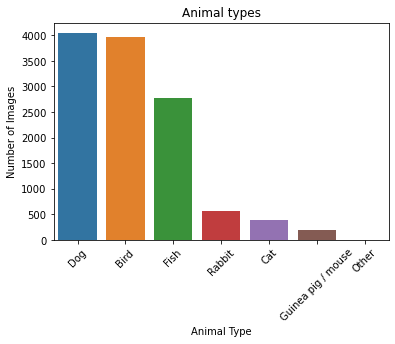

In [6]:
top_anim_type = df[["Image_File", "Animal_Type"]].groupby("Animal_Type").agg(['count'])['Image_File']['count'].sort_values(ascending=False)[:10]
fig = sns.barplot( x = top_anim_type.index, y = top_anim_type.values)
fig.set_xticklabels(labels=top_anim_type.index , rotation=45)
fig.set_ylabel("Number of Images")
fig.set_xlabel("Animal Type")
fig.set_title("Animal types");

Animal_Type은 Dog, Bird, Fish, Rabbit, Cat, Guinea pig/mouse, Other로 분류되고 가장 많은 동물의 종류는 Dog, 가장 적은 동물의 종류는 Guinea pig/mouse 이다.

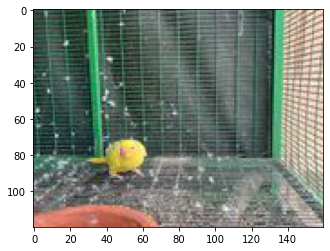

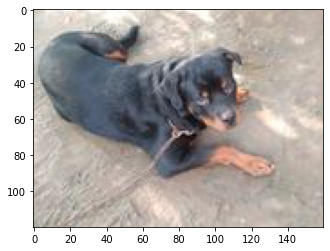

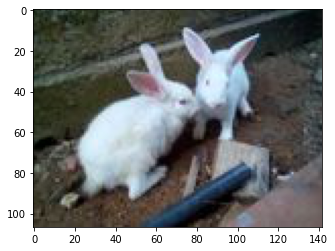

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

for i in range(0,3):
    image = Image.open(IMG_URL+df.iloc[i]["Image_File"])
    plt.imshow(image)
    plt.show()

In [8]:
image.size

(142, 107)

이미지 데이터 1개의 사이즈는 142*107이다.

## 3) 데이터 정제

In [9]:
Name = df['Animal_Type'].unique().tolist()
N=list(range(len(Name)))    
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 
df['Label']=df['Animal_Type'].map(normal_mapping)

In [10]:
normal_mapping

{'Bird': 0,
 'Dog': 1,
 'Rabbit': 2,
 'Fish': 3,
 'Cat': 4,
 'Guinea pig / mouse': 5,
 'Other': 6}

문자열로 되어있는 animal type에 숫자 label을 mapping 한 후, df에 'Label'열을 추가하였다.

In [11]:
X=[]
y=[]
for i in range(len(df)):
    labeli=df.loc[i,'Label']
    filei=df.loc[i,'Image_File']
    path=os.path.join(IMG_URL,filei)
    if os.path.isfile(path):
        image = Image.open(path)
        image = image.convert("RGB")
        image = image.resize((140, 140))
        data = np.asarray(image, dtype='float32')
        X.append(data)
        y.append(labeli)

    else:
        pass
    

In [12]:
path

'C:/Users/82105/Downloads/archive/animal_images/animal_images/1635693772831_Pomeranian Mixed Puppy for sale.jpg'

In [13]:
len(X), len(y)

(11365, 11365)

이미지 파일명에 특수문자가 있는 경우를 제외하고 데이터를 불러온다. <br>
불러온 데이터의 크기를 140*140으로 resize 한 후, 픽셀 array형태로 바꿔주었다. <br>
최종적으로 모형 훈련에 사용하는 데이터의 개수는 11365개이다.

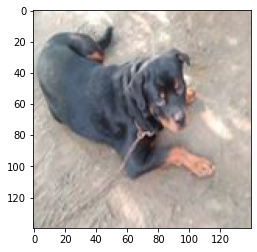

In [14]:
data = np.asarray(X[1], dtype='int32')
plt.imshow(data)

140*140으로 불러온 array를 이미지로 그려보면 위의 그림과 같다. 

In [15]:
X=np.asarray(X)/np.asarray(255.)
y=np.asarray(y)

training set과 test set으로 나누기 전, pixel값을 [0,1]범위의 값으로 변환시켰다.

In [16]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, stratify=y, random_state=2021)

In [17]:
len(X_train), len(X_test)

(7955, 3410)

training set과 test set을 7:3의 비율로 나눴다.

In [18]:
X_valid, X_train = X_train[:1000], X_train[1000:]
y_valid, y_train = y_train[:1000], y_train[1000:]

In [19]:
len(X_valid), len(X_train)

(1000, 6955)

이후 다시 training set을 train(6955개)/validation(1000개) 로 나누었다.

In [22]:
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

모델 적용에 앞서, to_categorical 함수를 이용해 label을 categorical로 바꿔주었다. 

## 4) CNN 모형 훈련

In [50]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(140,140,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))


In [51]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 138, 138, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 69, 69, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 67, 67, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 31, 31, 64)        36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


처음 Conv2D에서 input shape (140,140,3)을 받아 32개의 채널로 내보냈다. 이 때, 3*3 필터를 사용하였다. 
<br> 그 후, max pooling으로 shape를 반으로 줄였다. 이렇게 conv2D와 max pooling 과정을 두 번 더 반복한다.

In [52]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.5)) 
model.add(layers.Dense(7, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 138, 138, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 69, 69, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 67, 67, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 31, 31, 64)        36928     
_________________________________________________________________
flatten_6 (Flatten)          (None, 61504)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

위에서 나온 output (31,31,64)형태의 텐서를 조밀하게 연결된 분류기 망에 연결해야한다. <br>
따라서 layer_flatten을 이용하여 1D 벡터로 바꿔주어 연결하였다. 또한, dense 사이에 dropout을 넣어 overfitting을 방지하였다.<br>
마지막으로, 위 자료의 경우 7개의 class가 있으므로 7개의 output을 내보냈다.

In [53]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
history= model.fit(X_train, y_train, epochs=5,
                   batch_size=20, 
                   validation_data=(X_valid, y_valid))

Epoch 1/5
348/348 [==============================] - 72s 206ms/step - loss: 1.4523 - accuracy: 0.4229 - val_loss: 1.2062 - val_accuracy: 0.5430
Epoch 2/5
348/348 [==============================] - 72s 206ms/step - loss: 1.2068 - accuracy: 0.5737 - val_loss: 1.0600 - val_accuracy: 0.6100
Epoch 3/5
348/348 [==============================] - 73s 209ms/step - loss: 1.1160 - accuracy: 0.6190 - val_loss: 0.9898 - val_accuracy: 0.6760
Epoch 4/5
348/348 [==============================] - 74s 212ms/step - loss: 1.0664 - accuracy: 0.6541 - val_loss: 1.0248 - val_accuracy: 0.6250
Epoch 5/5
348/348 [==============================] - 73s 209ms/step - loss: 1.0317 - accuracy: 0.6561 - val_loss: 1.0048 - val_accuracy: 0.6570


optimizer함수는 rmsprop를 사용하였고, 위에서 label을 category로 바꿔주었기 때문에 loss function은 categorical crossentropy를 사용하였다.<br> epoch은 5로, batch size는 20으로 지정해서 모형을 fitting 시켰다.

In [54]:
test_loss, test_acc = model.evaluate(X_test, y_test)
test_acc

107/107 [==============================] - 6s 56ms/step - loss: 1.0418 - accuracy: 0.6504


0.6504398584365845

test set으로 모델의 accuracy와 loss를 살펴본 결과, accuracy는 0.6504, loss는 1.0418이 나왔다.

In [55]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


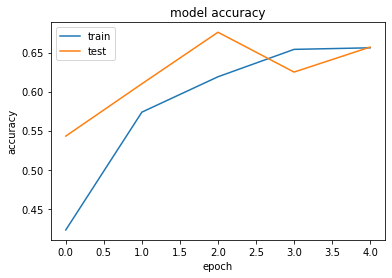

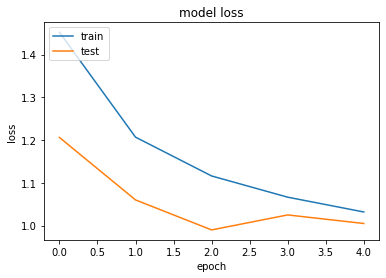

In [56]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

train set과 validation set의 accuracy와 loss를 그린 그래프이다. epoch 수가 작긴 하지만, train loss와 validation loss가 수렴하는 것으로 보아 overfitting 되지는 않았다.

## 5) CNN 모형 훈련 - 사전훈련망(VGG16) 이용

다음은 사전훈련망(VGG16)을 이용해 모형을 적합시켰다.

In [66]:
#vgg16 모델 불러오기
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

pre_trained_vgg = VGG16(weights='imagenet', 
                        include_top=False, 
                        input_shape=(140, 140, 3))
pre_trained_vgg.trainable = False
pre_trained_vgg.summary()

additional_model = models.Sequential()
additional_model.add(pre_trained_vgg)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(512,activation='relu'))
additional_model.add(Dropout(0.5)) 
additional_model.add(layers.Dense(256,activation='relu'))
additional_model.add(Dropout(0.5)) 
additional_model.add(layers.Dense(7,activation='sigmoid'))
additional_model.summary()


additional_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 140, 140, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 140, 140, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 140, 140, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 70, 70, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 70, 70, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 70, 70, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 35, 35, 128)       0     

image데이터를 이용하므로 weights에서 'imagenet'으로 지정하고, input_shape에는 우리 데이터의 shape인 (140,140,3)으로 지정하였다. <br>vgg16의 output은 (4,4,512)이고, 여기서 나온 output을 조밀하게 연결된 분류기의 입력으로 사용하였다. 

In [67]:
history = additional_model.fit(X_train, y_train, 
                    batch_size=20, 
                    epochs=5, 
                    validation_data=(X_valid, y_valid))

Epoch 1/5
348/348 [==============================] - 252s 723ms/step - loss: 0.2800 - acc: 0.6128 - val_loss: 0.2010 - val_acc: 0.7030
Epoch 2/5
348/348 [==============================] - 278s 800ms/step - loss: 0.2082 - acc: 0.7178 - val_loss: 0.1754 - val_acc: 0.7610
Epoch 3/5
348/348 [==============================] - 265s 761ms/step - loss: 0.1962 - acc: 0.7446 - val_loss: 0.1781 - val_acc: 0.7590
Epoch 4/5
348/348 [==============================] - 263s 756ms/step - loss: 0.1869 - acc: 0.7600 - val_loss: 0.1817 - val_acc: 0.7690
Epoch 5/5
348/348 [==============================] - 263s 755ms/step - loss: 0.1770 - acc: 0.7708 - val_loss: 0.1726 - val_acc: 0.7600


여기서도 batch size는 20, epoch은 5으로 지정하여 모델을 fitting 시켰다. 

In [68]:
test_loss, test_acc = additional_model.evaluate(X_test, y_test)
test_acc

107/107 [==============================] - 105s 978ms/step - loss: 0.1695 - acc: 0.7754


0.7753665447235107

그 결과 accuracy는 0.7753, loss는 0.1695로 사전훈련망(VGG16)을 사용한 모형이 더 성능이 좋다.

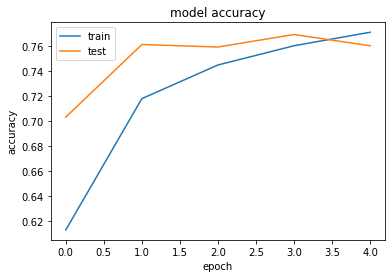

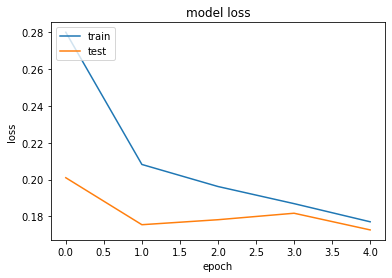

In [69]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

train set과 validation set의 accuracy와 loss를 그린 그래프이다. 
<br> epoch 수가 작긴 하지만, train loss와 validation loss가 수렴하는 것으로 보아 overfitting 되지는 않았다.

## 6) 결론

- 결론: 최종으로 동물 이미지 데이터 분류 예측을 위한 최적 모형은 사전훈련망(VGG16)을 이용한 모형이다.

- 느낀점: 분석을 진행하며 아쉬운 점은 컴퓨터의 성능 때문에 epoch 수를 너무 작게 잡아 모형이 overfitting이 된 것인지 정확히 보긴 어려웠고,  데이터 보강과 미세조정을 했다면 더 성능이 좋은 모형이 나왔을 것이라 기대한다.
